In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
sys.path.insert(0,'../py')

import desispec
import desispec.io
import desigal

### Select a couple of spectra for the demo

In [3]:
everest_path = Path("/global/cfs/cdirs/desi/spectro/redux/everest/")
tile_path = everest_path / "tiles/"
hpx_path = everest_path / "healpix"
exp_path = everest_path / "exposures"

sample_data_cum = tile_path / "cumulative/80605/20210205/coadd-0-80605-thru20210205.fits"
sample_data_hpx = hpx_path / "main/dark/100/10000/coadd-main-dark-10000.fits"
sample_data_cum_z = tile_path / "cumulative/80605/20210205/redrock-0-80605-thru20210205.fits"

z_cat = Table.read(sample_data_cum_z)
z_cat.add_index("TARGETID")
cum_spec = desispec.io.read_spectra(sample_data_cum)
# targets = [39627652591526038, 39627646576885987] # LRGS
targets = [39627646576885924, 39627640566454233] # QSO

spectra = cum_spec.select(targets=targets)
z_cat = z_cat.loc[targets]

INFO:spectra.py:285:read_spectra: iotime 0.726 sec to read coadd-0-80605-thru20210205.fits at 2022-04-28T18:31:58.489512


In [4]:
flux = spectra.flux
wave = spectra.wave
ivar = spectra.ivar
mask = spectra.mask
spec_z = z_cat["Z"]
fibermap = spectra.fibermap
exp_fibermap = spectra.exp_fibermap

# Do redshift Correction

The function takes either a `np.array` or a `dict`

In [5]:
flux_dered = desigal.redshift(flux,spec_z, 0 , "flux")
wave_dered = desigal.redshift(wave,spec_z, 0 , "wave")
ivar_dered = desigal.redshift(ivar,spec_z, 0 , "ivar")

Plot observed and de-redshifted flux for one spectra

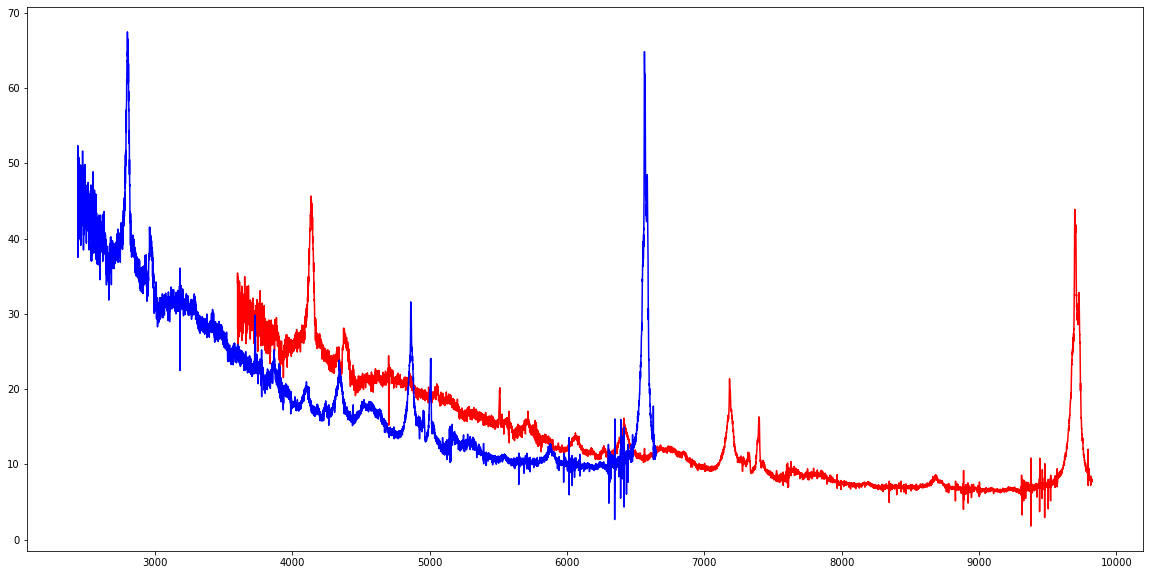

In [6]:
idx = 0
plt.figure(figsize=(20,10))
for cam in flux:
    plt.plot(wave[cam], flux[cam][idx], c= "red")
    plt.plot(wave_dered[cam][idx], flux_dered[cam][idx], c= "blue")

# Coadd Cameras

This is a faster alternative to `desispec.coaddition.coadd_cameras` but gives identical results.
It can handle redshifted spectra and has a vectorized implementation of the coaddition algorithm.
Currently this is not a full blown replacement for the `desispec` version as this does not merge fibermaps or does sanity checks.
For our specific purpose none of them are important and hence not implemented.

In [7]:
flux_coadd, wave_coadd, ivar_coadd, mask_coadd = desigal.coadd_cameras(flux_dered, wave_dered,ivar_dered,mask)

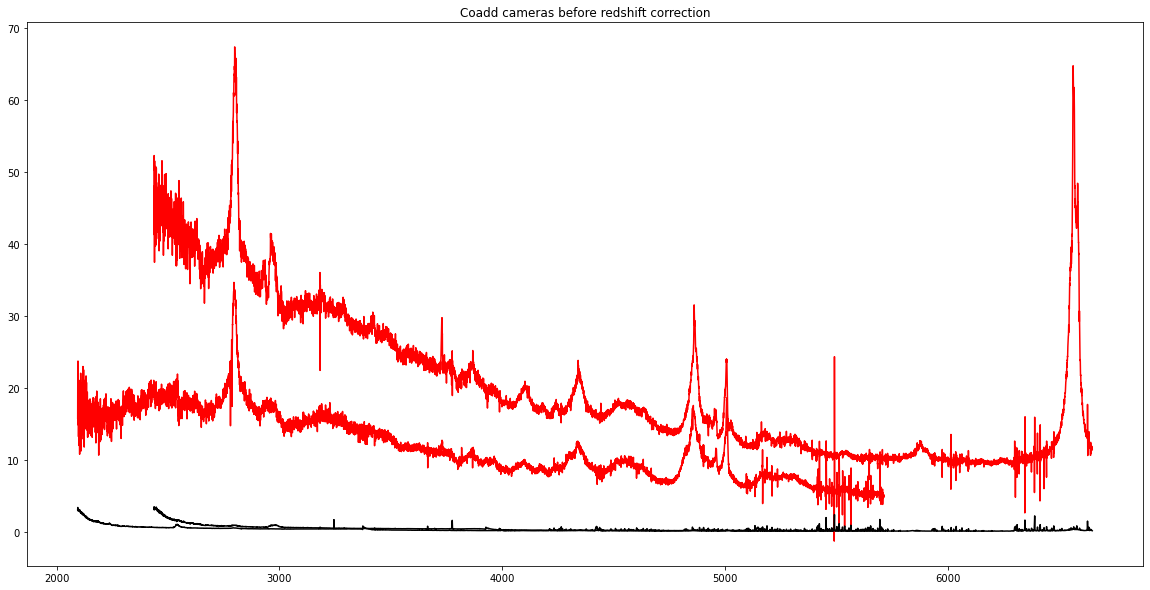

In [8]:
plt.figure(figsize=(20,10))
for idx in range(2):
    plt.plot(wave_coadd[idx], flux_coadd[idx], c= "red")
    plt.plot(wave_coadd[idx], 1/np.sqrt(ivar_coadd[idx]), c= "k")
    plt.title("Coadd cameras before redshift correction")

# Normalize the spectra

In [9]:
flux_normed, ivar_normed = desigal.normalize(flux_coadd,ivar_coadd, mask=mask, method="median")

/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


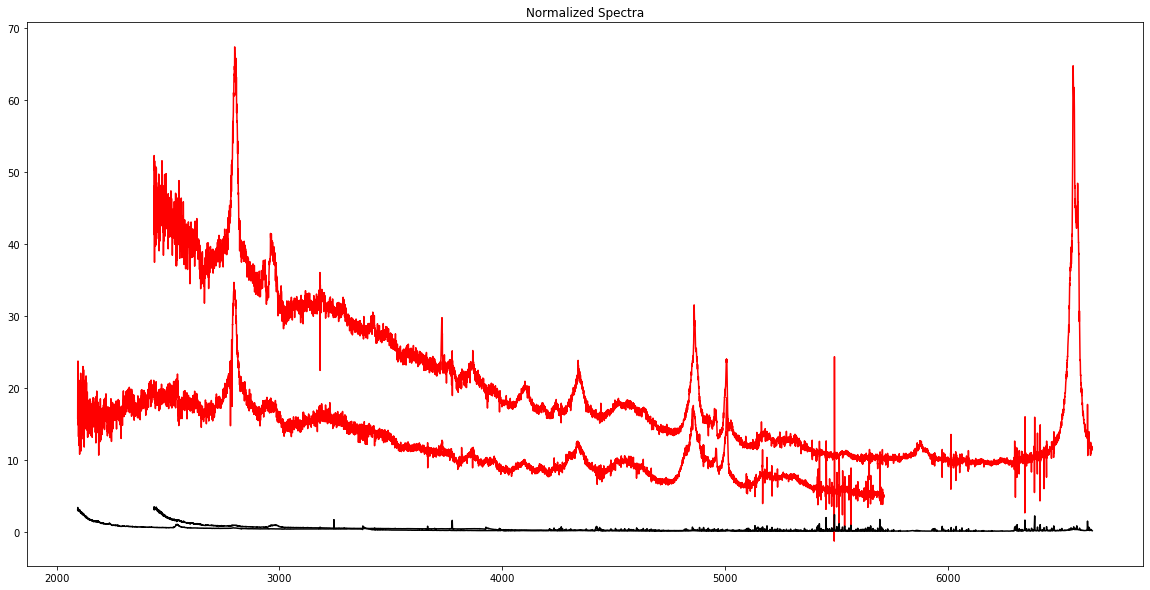

In [10]:
plt.figure(figsize=(20,10))
for idx in range(2):
    plt.plot(wave_coadd[idx], flux_normed[idx], c= "red")
    plt.plot(wave_coadd[idx], 1/np.sqrt(ivar_normed[idx]), c= "k")
    plt.title("Normalized Spectra")

# Resample to Common Grid

In [11]:
wave_grid = np.arange(np.min(wave_coadd), np.max(wave_coadd), 0.32)
flux_grid, ivar_grid = desigal.resample(wave_grid, wave_coadd, flux_normed, ivar_normed, verbose=False, fill=np.nan, method="linear")

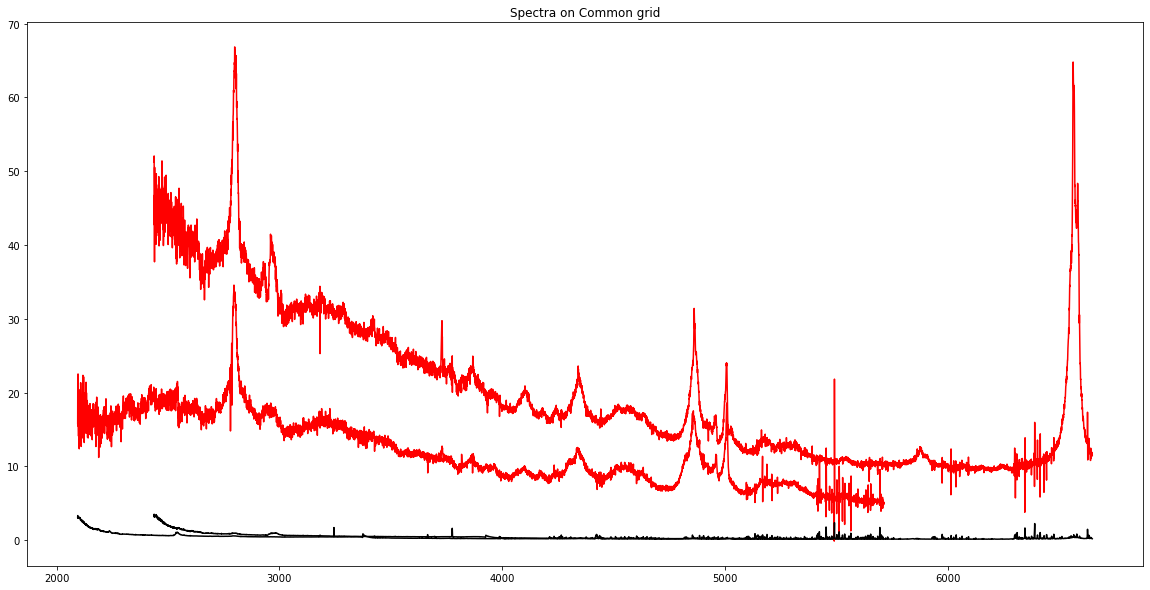

In [12]:
plt.figure(figsize=(20,10))
for idx in range(2):
    plt.plot(wave_grid, flux_grid[idx], c= "red")
    plt.plot(wave_grid, 1/np.sqrt(ivar_grid[idx]), c= "k")
    plt.title("Spectra on Common grid")

# Model the IVAR using Sky

### before that lets get the sky

In [13]:
sky_flux, sky_mask = desigal.get_sky(fibermap = fibermap, exp_fibermap=exp_fibermap)

sky_flux_coadd, wave_coadd, ivar_coadd, mask_coadd = desigal.coadd_cameras(sky_flux, wave, ivar, sky_mask)

INFO:sky.py:98:read_sky: iotime 0.102 sec to read sky-b0-00068292.fits at 2022-04-28T18:32:18.003025
INFO:fluxcalibration.py:189:read_flux_calibration: iotime 0.047 sec to read fluxcalib-b0-00068292.fits at 2022-04-28T18:32:18.051196
INFO:fibermap.py:291:read_fibermap: iotime 0.104 sec to read cframe-b0-00068292.fits at 2022-04-28T18:32:18.235371
INFO:frame.py:217:read_frame: iotime 0.232 sec to read cframe-b0-00068292.fits at 2022-04-28T18:32:18.285156
INFO:fluxcalibration.py:1435:apply_flux_calibration: starting
INFO:sky.py:98:read_sky: iotime 0.119 sec to read sky-b0-00073704.fits at 2022-04-28T18:32:18.807731
INFO:fluxcalibration.py:189:read_flux_calibration: iotime 0.093 sec to read fluxcalib-b0-00073704.fits at 2022-04-28T18:32:18.902596
INFO:sky.py:98:read_sky: iotime 0.121 sec to read sky-b0-00067711.fits at 2022-04-28T18:32:19.116342
INFO:fibermap.py:291:read_fibermap: iotime 0.159 sec to read cframe-b0-00073704.fits at 2022-04-28T18:32:19.155454
INFO:fluxcalibration.py:189:re

In [14]:
sky_flux_coadd, wave_coadd, ivar_coadd, mask_coadd = desigal.coadd_cameras(sky_flux, wave, ivar, sky_mask)

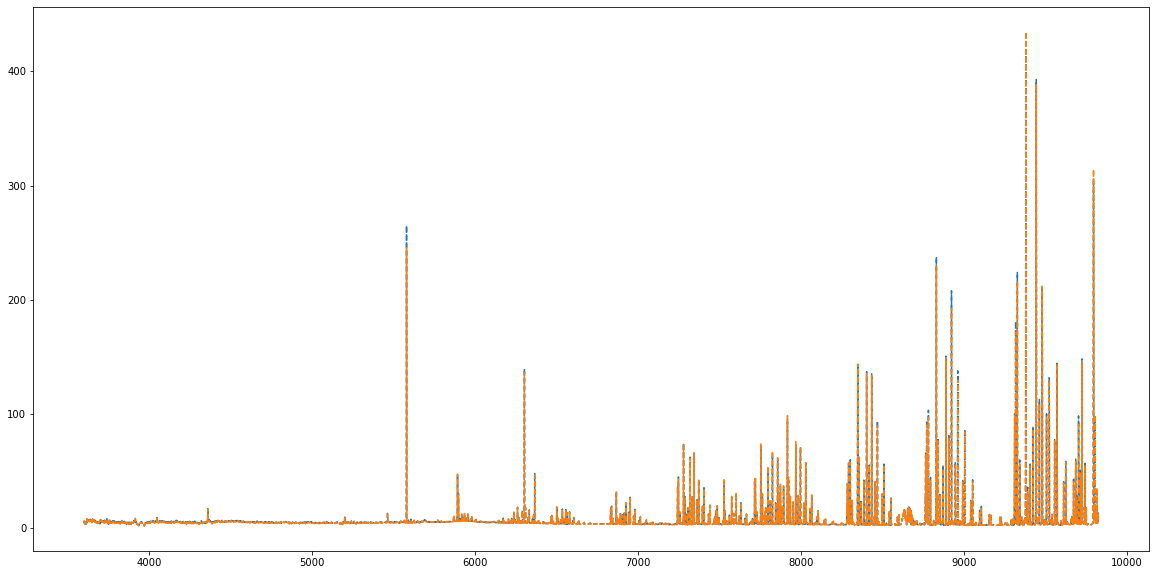

In [15]:
plt.figure(figsize=(20,10))
for idx in range(2):
    plt.plot(wave_coadd, sky_flux_coadd[idx], ls="--")

### Now lets model the error using Sky

P.S: Algorithm currently optimized to take sky ivar as input, therefore needs an update to work with sky

In [16]:
ivar_model= desigal.model_ivar(ivar_coadd, sky_flux_coadd, wave_coadd)

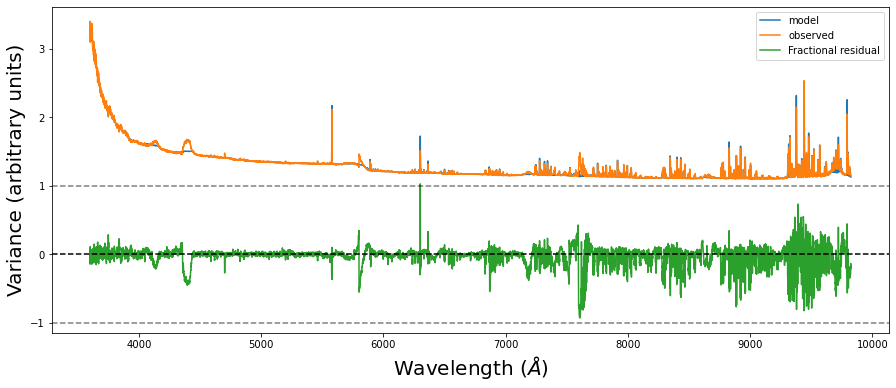

In [17]:
index = 0

plt.figure(figsize=(15,6))
plt.plot(wave_coadd, 1/np.sqrt(ivar_model[index])+1, label="model")
plt.plot(wave_coadd, 1/np.sqrt(ivar_coadd[index])+1, label ="observed")
plt.plot(wave_coadd, ((1/ivar_model[index])-(1/ivar_coadd[index]))/(1/ivar_coadd[index]), label="Fractional residual")
plt.legend(fontsize=10)
plt.ylabel("Variance (arbitrary units)",size=20)
plt.xlabel("Wavelength ($\AA$)", size=20)
plt.axhline(0, ls="--", c="k")
plt.axhline(-1, ls="--", c="k", alpha=0.5)
plt.axhline(1, ls="--", c="k", alpha=0.5)

# `stack_spectra()`: One Function to Rule Them All

In [18]:
stacked_spectra, wave_grid = desigal.stack_spectra(flux,
                                wave,
                                ivar,
                                mask,
                                spec_z,
                                fibermap,
                                exp_fibermap,
                                norm_method = "median",
                                resample_method = "linear",
                                stack_method = "mean", #median , ivar
                                weight = "none",
                                stack_error = "none" #bootstrap
                               )

/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


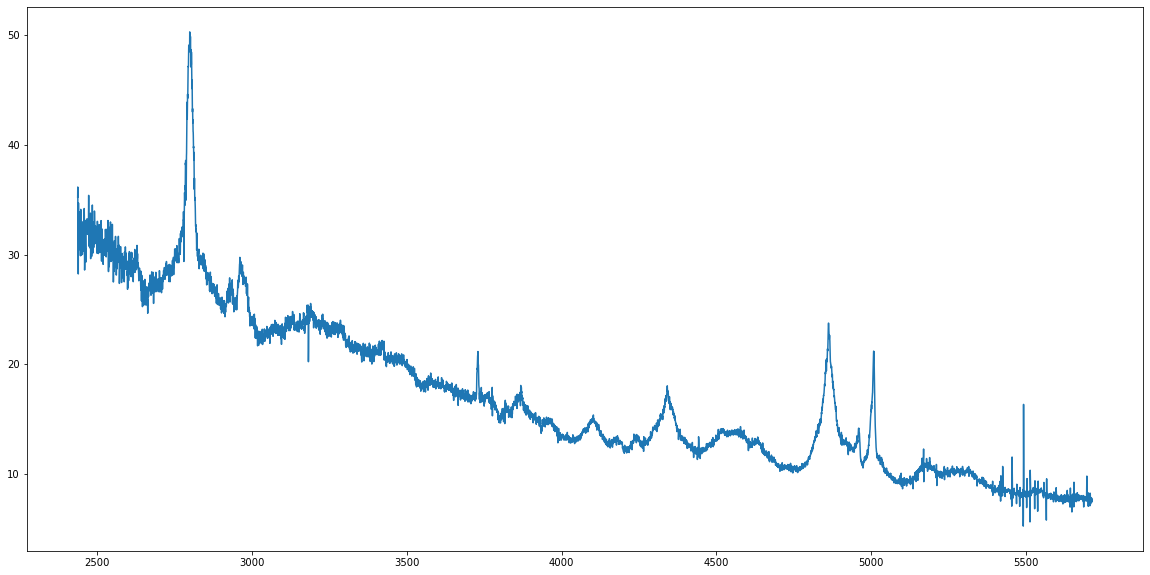

In [19]:
plt.figure(figsize=(20,10))
plt.plot(wave_grid, stacked_spectra)